In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
btc_price = pd.read_csv(
    "../data/raw/btc_prices.csv",
    parse_dates = ["date"]
)

nifty_price = pd.read_csv(
    "../data/raw/nifty_prices.csv",
    parse_dates = ["date"]
)

sent = pd.read_csv(
    "../data/processed/text_with_sentiment.csv",
    parse_dates = ["timestamp"]
)

In [3]:
btc_price["date"] = btc_price["date"].dt.tz_localize(None)
nifty_price["date"] = nifty_price["date"].dt.tz_localize(None)
sent["date"] = sent["timestamp"].dt.tz_localize(None).dt.to_period("M").dt.to_timestamp()

In [4]:
btc_price = pd.read_csv(
    "../data/raw/btc_prices.csv",
    parse_dates=["date"]
)

nifty_price = pd.read_csv(
    "../data/raw/nifty_prices.csv",
    parse_dates=["date"]
)

btc_price["date"] = pd.to_datetime(btc_price["date"]).dt.tz_localize(None)
nifty_price["date"] = pd.to_datetime(nifty_price["date"]).dt.tz_localize(None)

btc_price.head(), nifty_price.head()

(        date        open        high         low       close    volume  \
 0 2015-01-02  314.079010  315.838989  313.565002  315.032013   7860650   
 1 2015-01-03  314.846008  315.149994  281.082001  281.082001  33054400   
 2 2015-01-04  281.145996  287.230011  257.612000  264.195007  55629100   
 3 2015-01-05  265.084015  278.341003  265.084015  274.473999  43962800   
 4 2015-01-06  274.610992  287.553009  272.696014  286.188995  23245700   
 
      return  
 0  0.002492  
 1 -0.107767  
 2 -0.060079  
 3  0.038907  
 4  0.042682  ,
         date         open         high          low        close  volume  \
 0 2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902       0   
 1 2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805       0   
 2 2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098       0   
 3 2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000       0   
 4 2010-01-11  5263.799805  5287.200195  5227.799805  5249.399902       

In [5]:
btc_monthly_price = (
    btc_price
    .set_index("date")
    .resample("ME")
    .agg(close_price=("close", "last"))
    .reset_index()
)

nifty_monthly_price = (
    nifty_price
    .set_index("date")
    .resample("ME")
    .agg(close_price=("close", "last"))
    .reset_index()
)

In [6]:
btc_monthly_sent = (
    sent[sent["asset"] == "BTC"]
    .set_index("date")
    .resample("ME")
    .agg(sentiment=("finbert_score", "mean"))
    .reset_index()
)

nifty_monthly_sent = (
    sent[sent["asset"] == "NIFTY"]
    .set_index("date")
    .resample("ME")
    .agg(sentiment=("finbert_score", "mean"))
    .reset_index()
)

In [7]:
btc_plot_df = pd.merge(
    btc_monthly_price,
    btc_monthly_sent,
    on="date",
    how="inner"
)

nifty_plot_df = pd.merge(
    nifty_monthly_price,
    nifty_monthly_sent,
    on="date",
    how="inner"
)

btc_plot_df.head()

,date,close_price,sentiment
0,2024-10-31,70215.187500,0.560580
1,2024-11-30,96449.054688,0.286030
2,2024-12-31,93429.203125,0.310285
3,2025-01-31,102405.023438,0.144828


In [8]:
scaler = MinMaxScaler()

btc_plot_df[["price_scaled", "sentiment_scaled"]] = scaler.fit_transform(
    btc_plot_df[["close_price", "sentiment"]]
)

nifty_plot_df[["price_scaled", "sentiment_scaled"]] = scaler.fit_transform(
    nifty_plot_df[["close_price", "sentiment"]]
)

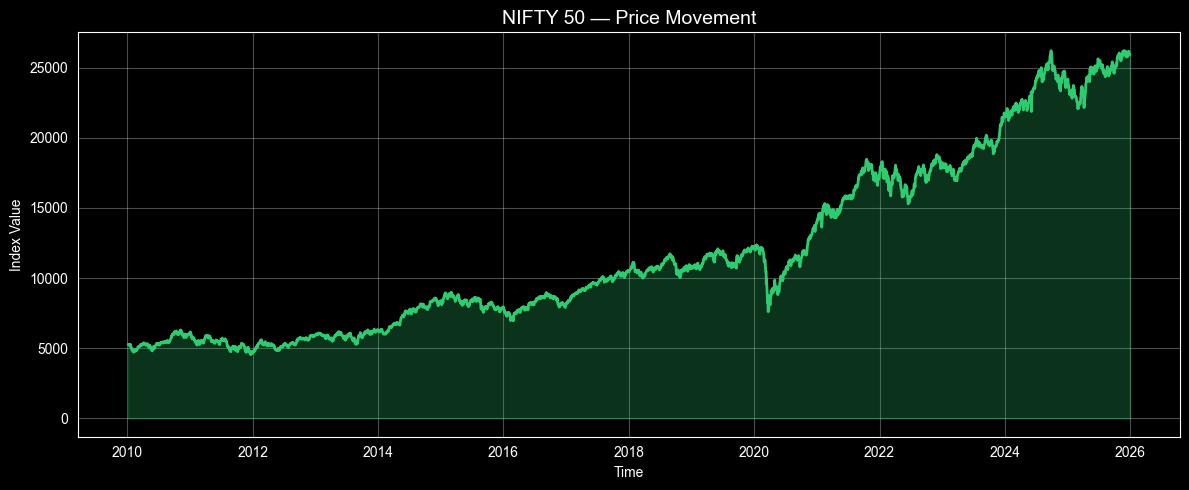

In [9]:
plt.figure(figsize=(12,5))

plt.plot(
    nifty_price["date"],
    nifty_price["close"],
    color="#2ecc71",
    linewidth=2
)

plt.fill_between(
    nifty_price["date"],
    nifty_price["close"],
    color="#2ecc71",
    alpha=0.25
)

plt.title("NIFTY 50 — Price Movement", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Index Value")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


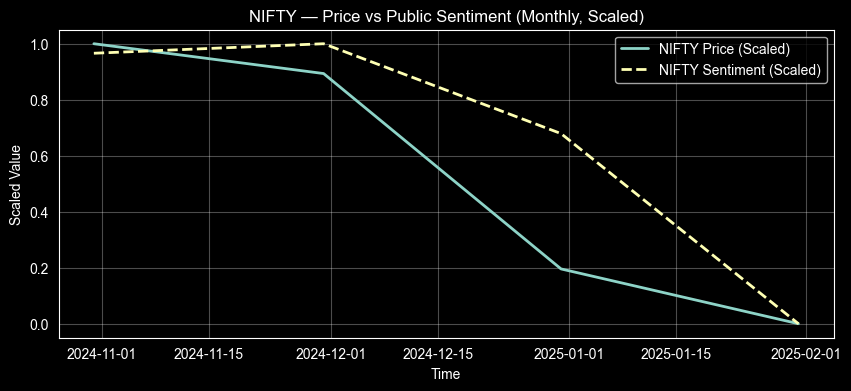

In [20]:
plt.figure(figsize=(10,4))
plt.plot(
    nifty_plot_df["date"],
    nifty_plot_df["price_scaled"],
    label="NIFTY Price (Scaled)",
    linewidth=2
)
plt.plot(
    nifty_plot_df["date"],
    nifty_plot_df["sentiment_scaled"],
    label="NIFTY Sentiment (Scaled)",
    linestyle="--",
    linewidth=2
)
plt.title("NIFTY — Price vs Public Sentiment (Monthly, Scaled)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [21]:
btc_corr = btc_plot_df[["price_scaled", "sentiment_scaled"]].corr()
nifty_corr = nifty_plot_df[["price_scaled", "sentiment_scaled"]].corr()

btc_corr, nifty_corr
#END

(                  price_scaled  sentiment_scaled
 price_scaled           1.00000          -0.98367
 sentiment_scaled      -0.98367           1.00000,
                   price_scaled  sentiment_scaled
 price_scaled          1.000000          0.880837
 sentiment_scaled      0.880837          1.000000)

In [ ]:
def pre_event_stats(df, lag):
    events = df[df["stress"] == 1]
    rows = []

    for _, row in events.iterrows():
        d = row["date"]
        prev = df[df["date"] == d - pd.Timedelta(days=lag)]
        if not prev.empty:
            rows.append(prev.iloc[0])

    return pd.DataFrame(rows)

In [ ]:
btc_t1 = pre_event_stats(btc_me, 1)
btc_t3 = pre_event_stats(btc_me, 3)
btc_t7 = pre_event_stats(btc_me, 7)

In [ ]:
btc_normal = btc_m[btc_m["stress"] == 0].sample(len(btc_t3), random_state=42)

In [ ]:
comparison = pd.DataFrame({
    "Pre-Stress (t-3)": btc_t3["sent_surprise"].mean(),
    "Normal Days": btc_normal["sent_surprise"].mean()
}, index=["Sentiment Surprise"])
comparison

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(btc_t3["sent_surprise"], bins=30, alpha=0.6, label="Before Stress")
plt.hist(btc_normal["sent_surprise"], bins=30, alpha=0.6, label="Normal")
plt.legend()
plt.title("BTC — Sentiment Surprise Before Stress Events")
plt.show()